In [ ]:
# competition: https://www.kaggle.com/competitions/nlp-getting-started/overview
# just change the model (and a bit architecture) and train it

In [ ]:
#!pip uninstall pyarrow

In [ ]:
!pip install transformers datasets pyarrow==15.0.2 -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from datasets import Dataset
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer

In [ ]:
model_name = 'google-bert/bert-base-uncased'#'jinaai/jina-embeddings-v3' -> they much better

In [ ]:
# dataset

In [4]:
df = pd.read_csv('/content/train (1).csv')

In [5]:
df.sample(3)

,id,keyword,location,text,target
918,1328,bloody,"Santa Cruz, CA",Black Friday turns Bloody (would rather be sho...,0
1424,2056,casualties,"Northern Kentucky, USA",@irishspy What you don't think the Allies shou...,1
7367,10548,windstorm,NaN,WindStorm WSVR1686B Cover for V-Hull Runabout ...,0


In [6]:
df.shape

(7613, 5)

In [7]:
df.fillna('None', inplace=True)

In [8]:
df['input'] = '<Text>: ' + df['text'] + ' <Keyword>: ' + df['keyword'] + ' <Location>: ' + df['location']

In [9]:
df.iloc[100]['input']

'<Text>: .@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad <Keyword>: accident <Location>: UK'

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['input'],
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42)

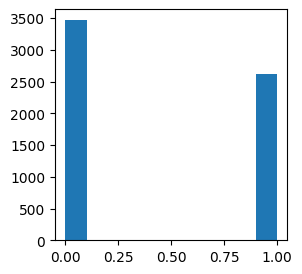

In [ ]:
plt.figure(figsize=(3, 3))
plt.hist(y_train); # as we see classes are almost balanced

In [ ]:
# dataloaders

In [10]:
dataset = Dataset.from_pandas(df[['input', 'target']].reset_index(drop=True))

In [11]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [12]:
train_dataset = dataset['train'].shuffle()
test_dataset = dataset['test']

In [13]:
train_dataset, test_dataset

(Dataset({
     features: ['input', 'target'],
     num_rows: 6090
 }),
 Dataset({
     features: ['input', 'target'],
     num_rows: 1523
 }))

In [ ]:
# tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
maxi = 0
for text in df['input']:
  maxi = max(maxi, len(tokenizer(text)['input_ids']))

maxi # max number of tokens in one example from input

106

In [16]:
def preprocess_func(examples):
  inputs = tokenizer(examples['input'], truncation=True,
                     max_length=512, padding='max_length')

  inputs['target'] = torch.Tensor(examples['target'])
  return inputs

In [17]:
tokenized_train_dataset = train_dataset.map(preprocess_func, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_func, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [18]:
# very important -> in order not to get errors with dims
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'target'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'target'])

In [19]:
tokenized_train_dataset

Dataset({
    features: ['input', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6090
})

In [ ]:
# dataloader

In [20]:
tokenized_train_set = tokenized_train_dataset.select_columns(['input_ids', 'target', 'attention_mask'])
tokenized_test_set = tokenized_test_dataset.select_columns(['input_ids', 'target', 'attention_mask'])

In [21]:
tokenized_train_set.set_format(type='torch', columns=['input_ids', 'target', 'attention_mask'])
tokenized_test_set.set_format(type='torch', columns=['input_ids', 'target', 'attention_mask'])

In [22]:
train_loader = DataLoader(tokenized_train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_test_set, batch_size=16)

In [23]:
for batch in train_loader:
    input_ids = batch['input_ids']
    target = batch['target']
    attn_mask = batch['attention_mask']
    print(input_ids.shape)
    print(target.shape)
    print(attn_mask.shape)
    break

torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])


In [ ]:
# model

In [24]:
class clf(nn.Module):
  def __init__(self, hid_size=768, num_classes=2):
    super().__init__()
    self.model = AutoModel.from_pretrained(model_name,
                                           trust_remote_code=True)
    self.ln1 = nn.Linear(hid_size, num_classes)

  def forward(self, x, attn_mask):
    embeddings = self.model(x, attention_mask=attn_mask).pooler_output
    #embeddings = embeddings.to(dtype=torch.float) # for jina embeddings v3
    return self.ln1(embeddings)

In [ ]:
model = clf(hid_size=768, num_classes=2).to('cuda')

In [26]:
print(sum([param.numel() for param in model.parameters()]))
sum([param.numel() for param in model.parameters() if param.requires_grad==True])

109483778


109483778

In [27]:
# experiment with it (change which layers to freeze or unfreeze)
# let's start from freezing all the weights, excluding linear clf head
for name, param in model.named_parameters():
  param.requires_grad = False
  if name.startswith('ln1'):
    param.requires_grad = True

sum([param.numel() for param in model.parameters() if param.requires_grad==True])

1538

In [28]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [30]:
epochs = 6 # tune it
model.train()
for i in range(epochs):
  cum_loss = 0.0
  for batch in tqdm(train_loader):
    x = batch['input_ids'].to('cuda')
    target = batch['target'].to('cuda')
    attn_mask = batch['attention_mask'].to('cuda')

    logits = model(x, attn_mask=attn_mask)
    loss = criterion(logits, target)

    optim.zero_grad()
    loss.backward()
    optim.step()

    cum_loss += loss.item()

  print(f'epoch: {i+1}, ce_loss: {cum_loss/len(train_loader)}')

  model.eval()
  cum_val_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad():
      for batch in tqdm(test_loader):
          x = batch['input_ids'].to('cuda')
          target = batch['target'].to('cuda')
          attn_mask = batch['attention_mask'].to('cuda')

          logits = model(x, attn_mask=attn_mask)
          val_loss = criterion(logits, target)

          cum_val_loss += val_loss.item()

          preds = torch.argmax(logits, dim=-1)
          correct_predictions += (preds == target).sum().item()
          total_predictions += target.size(0)

  avg_val_loss = cum_val_loss / len(test_loader)
  accuracy = correct_predictions / total_predictions

  print(f'Epoch: {i+1}, Validation Loss: {avg_val_loss}, Accuracy: {accuracy}')

100%|██████████| 381/381 [03:01<00:00,  2.10it/s]


epoch: 1, ce_loss: 0.6418405772037706


100%|██████████| 96/96 [00:45<00:00,  2.11it/s]


Epoch: 1, Validation Loss: 0.5973643076916536, Accuracy: 0.695994747209455


100%|██████████| 381/381 [03:02<00:00,  2.09it/s]


epoch: 2, ce_loss: 0.5925755827758569


100%|██████████| 96/96 [00:46<00:00,  2.09it/s]


Epoch: 2, Validation Loss: 0.5753079786275824, Accuracy: 0.7078135259356533


100%|██████████| 381/381 [03:02<00:00,  2.08it/s]


epoch: 3, ce_loss: 0.5744472248504168


100%|██████████| 96/96 [00:46<00:00,  2.07it/s]


Epoch: 3, Validation Loss: 0.5667597387606899, Accuracy: 0.7229152987524623


100%|██████████| 381/381 [03:02<00:00,  2.08it/s]


epoch: 4, ce_loss: 0.5600003733878999


100%|██████████| 96/96 [00:45<00:00,  2.11it/s]


Epoch: 4, Validation Loss: 0.5445111803710461, Accuracy: 0.7413000656598818


100%|██████████| 381/381 [03:01<00:00,  2.10it/s]


epoch: 5, ce_loss: 0.5482007089092975


100%|██████████| 96/96 [00:45<00:00,  2.10it/s]


Epoch: 5, Validation Loss: 0.5336303878575563, Accuracy: 0.7426132632961261


100%|██████████| 381/381 [03:02<00:00,  2.09it/s]


epoch: 6, ce_loss: 0.5398935469116751


100%|██████████| 96/96 [00:45<00:00,  2.10it/s]


Epoch: 6, Validation Loss: 0.5267183982456723, Accuracy: 0.7452396585686146


 45%|████▍     | 171/381 [01:22<01:41,  2.07it/s]


KeyboardInterrupt: 

In [ ]:
# evaluation

In [31]:
from sklearn.metrics import accuracy_score, classification_report

In [40]:
def get_predictions(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in tqdm(test_loader):
        x = batch['input_ids'].to('cuda')
        target = batch['target'].to('cuda')
        attn_mask = batch['attention_mask'].to('cuda')

        with torch.no_grad():
            outputs = model(x, attn_mask=attn_mask)

        logits = outputs.detach().cpu().numpy()
        label_ids = target.cpu().numpy()

        predictions.extend(logits.argmax(axis=-1))
        true_labels.extend(label_ids)

    return np.array(predictions), np.array(true_labels)

predictions, true_labels = get_predictions(model, test_loader)
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, digits=4)

print(f"Validation Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

100%|██████████| 96/96 [00:44<00:00,  2.17it/s]

Validation Accuracy: 0.7505
Classification Report:
              precision    recall  f1-score   support

           0     0.7691    0.8062    0.7872       872
           1     0.7225    0.6759    0.6984       651

    accuracy                         0.7505      1523
   macro avg     0.7458    0.7410    0.7428      1523
weighted avg     0.7492    0.7505    0.7493      1523



In [ ]:
# preparation for submitting

In [41]:
test_df = pd.read_csv('/content/test.csv')

In [65]:
test_df.tail(3)

,id,keyword,location,text,input
3260,10868,None,None,Green Line derailment in Chicago http://t.co/U...,<Text>: Green Line derailment in Chicago http:...
3261,10874,None,None,MEG issues Hazardous Weather Outlook (HWO) htt...,<Text>: MEG issues Hazardous Weather Outlook (...
3262,10875,None,None,#CityofCalgary has activated its Municipal Eme...,<Text>: #CityofCalgary has activated its Munic...


In [43]:
test_df.shape

(3263, 4)

In [44]:
test_df.fillna('None', inplace=True)

In [45]:
test_df['input'] = '<Text>: ' + test_df['text'] + ' <Keyword>: ' + test_df['keyword'] + ' <Location>: ' + test_df['location']

In [46]:
test_df.iloc[100]['input']

'<Text>: BROOO HE JUST GOT ANNIHILATED https://t.co/UR7QkqG1wf <Keyword>: annihilated <Location>: None'

In [67]:
val_dataset = Dataset.from_pandas(test_df[['input', 'id']].reset_index(drop=True))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [69]:
def preprocess_func(examples):
  inputs = tokenizer(examples['input'], truncation=True,
                     max_length=512, padding='max_length')
  inputs['id'] = examples['id']
  return inputs

In [70]:
tokenized_val_dataset = val_dataset.map(preprocess_func, batched=True)

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [71]:
# very important -> in order not to get errors with dims
tokenized_val_dataset.set_format(type='torch', columns=['input_ids'])

In [72]:
tokenized_val_dataset

Dataset({
    features: ['input', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [ ]:
# dataloader

In [79]:
tokenized_val_set = tokenized_val_dataset.select_columns(['id', 'input_ids', 'attention_mask'])

In [80]:
tokenized_val_set.set_format(type='torch', columns=['id', 'input_ids', 'attention_mask'])

In [81]:
val_loader = DataLoader(tokenized_val_set, batch_size=16)

In [82]:
for batch in val_loader:
    input_ids = batch['input_ids']
    attn_mask = batch['attention_mask']
    id = batch['id']
    print(id.shape)
    print(input_ids.shape)
    print(attn_mask.shape)
    break

torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])


In [ ]:
# final set validation (test)

In [84]:
model.eval()
preds = []
idxs = []
for batch in tqdm(val_loader):
  ids = batch['id']
  input_ids = batch['input_ids'].to('cuda')
  attn_mask = batch['attention_mask'].to('cuda')

  with torch.no_grad():
    outputs = model(input_ids, attn_mask=attn_mask)

  logits = outputs.detach().cpu().numpy()
  preds.extend(logits.argmax(axis=-1))

  idx = ids.detach().cpu().numpy()
  idxs.extend(idx)

100%|██████████| 204/204 [01:35<00:00,  2.13it/s]


In [87]:
print(len(preds))
print(len(idxs))

3263
3263


In [89]:
data = list(zip(idxs, preds))

In [90]:
result_df = pd.DataFrame(data, columns=['id', 'target'])

In [91]:
result_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [92]:
result_df.to_csv('result1.csv', index=False)